<a href="https://colab.research.google.com/github/robjmenna/RBE595_deeplearning_final/blob/main/resnet151.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

size: (150, 187, 3)
label: English foxhound


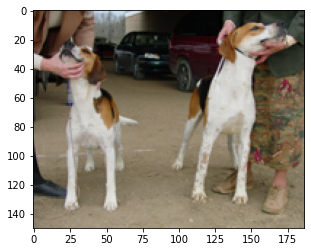

In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import requests
import tensorflow_datasets as tfds

def imagenetlabels():
    """Download the list of labels of the imagenet dataset"""
    label_url = 'https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt'
    blob = requests.get(label_url).text.split('\n')
    labels = [str(line) for line in blob[1:]]
    return labels

data = tfds.load('imagenet2012_subset')
train = data['train'].map(lambda x: (x['image'], x['label']))
labels = imagenetlabels()
ex = next(train.skip(10).take(1).as_numpy_iterator())
plt.figure()
plt.imshow(ex[0])
print('size: ' + str(ex[0].shape))
print('label: ' + labels[ex[1]])

In [28]:
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense

def preprocess(dataset, batch_size, shuffle_buffer_size, input_shape=[224,224], num_classes=1000):
    dataset.map(lambda x: (x['image'], x['label'])
          ).map(lambda x, y: (tf.image.resize(x, input_shape, method='nearest'),y)
          ).map(lambda x, y: (tf.cast(x, tf.float32) / 255.0, tf.one_hot(y, num_classes))
          ).shuffle(batch_size
          ).batch(shuffle_buffer_size)

def create_model():
    model = Sequential()
    model.add(Conv2D(256, 3, input_shape=(224,224,3), activation="relu", padding="same"))
    model.add(Conv2D(256, 3, activation="relu", padding="same"))
    model.add(MaxPooling2D())
    model.add(Conv2D(128, 3, activation="relu", padding="same"))
    model.add(Conv2D(128, 3, activation="relu", padding="same"))
    model.add(MaxPooling2D())
    model.add(Conv2D(64, 3, activation="relu", padding="same"))
    model.add(Conv2D(64, 3, activation="relu", padding="same"))
    model.add(MaxPooling2D())
    model.add(Flatten())
    model.add(Dense(500, activation="relu"))
    model.add(Dense(500, activation="relu"))
    model.add(Dense(1000, activation="softmax"))
    model.compile(
        optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"]
    )
    return model

def create_resnet():
    m = tf.keras.Sequential([
        hub.KerasLayer("https://tfhub.dev/google/imagenet/resnet_v2_152/classification/4")
    ])
    m.build([None, 224, 224, 3])  # Batch input shape.
    return m

train = preprocess(data['train'], 10, 20)
val = preprocess(data['validation'], 10, 20)

calllist = [TensorBoard('./logs', histogram_freq=1), ModelCheckpoint('./models/facestudent', save_best_only=True)]
model = create_model()
print(model.summary())
batch_size=10
model.fit(train, epochs=10, callbacks=calllist, validation_data=val)

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_48 (Conv2D)           (None, 224, 224, 256)     7168      
_________________________________________________________________
conv2d_49 (Conv2D)           (None, 224, 224, 256)     590080    
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 112, 112, 256)     0         
_________________________________________________________________
conv2d_50 (Conv2D)           (None, 112, 112, 128)     295040    
_________________________________________________________________
conv2d_51 (Conv2D)           (None, 112, 112, 128)     147584    
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 56, 56, 128)       0         
_________________________________________________________________
conv2d_52 (Conv2D)           (None, 56, 56, 64)       

KeyboardInterrupt: 

In [1]:
from utils import Distiller
from utils import preprocess
from utils import imagenetlabels
from students import facemodel
import tensorflow_hub as hub
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint
import tensorflow_datasets as tfds
from tensorflow import keras
from tensorflow.keras.layers import Dense
import matplotlib.pyplot as plt

teacher = tf.keras.Sequential([
        hub.KerasLayer("https://tfhub.dev/google/imagenet/resnet_v2_152/feature_vector/4"),
        Dense(1001)
          # Can be True, see below.
    ])
teacher.build([None, 224, 224, 3])  # Batch input shape.
student = facemodel.create_model()

callback_list = [ModelCheckpoint('./models/distilled/weights.{epoch:02d}-{val_loss:.2f}.hdf5', save_best_only=True)]
distiller = Distiller(student=student, teacher=teacher)
distiller.compile(
    optimizer=keras.optimizers.Adam(),
    metrics=[keras.metrics.CategoricalAccuracy()],
    student_loss_fn=keras.losses.CategoricalCrossentropy(from_logits=True),
    distillation_loss_fn=keras.losses.KLDivergence(),
    alpha=0.1,
    temperature=10,
)

data = tfds.load('imagenet2012_subset', data_dir='D:\\tensorflow_datasets')
batch_size = 10
input_shape=[224,224]
labels = imagenetlabels()
num_classes = 1001
train = data['train'].map(lambda x: (x['image'], x['label'])
          ).map(lambda x, y: (tf.image.resize(x, input_shape, method='nearest'),y)
          ).map(lambda x, y: (tf.cast(x, tf.float32) / 255.0, tf.one_hot(y, num_classes))
          ).shuffle(batch_size
          ).batch(30)
validate = data['validation'].map(lambda x: (x['image'], x['label'])
          ).map(lambda x, y: (tf.image.resize(x, input_shape, method='nearest'),y)
          ).map(lambda x, y: (tf.cast(x, tf.float32) / 255.0, tf.one_hot(y, num_classes))
          ).shuffle(batch_size
          ).batch(30)

labels = imagenetlabels()
ex = next(train.unbatch().skip(10).take(1).as_numpy_iterator())
plt.figure()
plt.imshow(ex[0])

# Distill teacher to student
distiller.fit(x=train, epochs=3, validation_data=validate, callbacks=callback_list)

# Evaluate student on test dataset
distiller.evaluate(validate)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 256)     7168      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 224, 224, 256)     590080    
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 256)     0         
_________________________________________________________________
dropout (Dropout)            (None, 112, 112, 256)     0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 112, 112, 128)     295040    
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 112, 112, 128)     147584    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 128)       0

ResourceExhaustedError:  OOM when allocating tensor with shape[30,256,224,224] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node gradient_tape/sequential_2/max_pooling2d_3/MaxPool/MaxPoolGrad (defined at c:\Users\robjm\Documents\GitHub\RBE595_deeplearning_final\utils.py:101) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.
 [Op:__inference_train_function_39380]

Errors may have originated from an input operation.
Input Source operations connected to node gradient_tape/sequential_2/max_pooling2d_3/MaxPool/MaxPoolGrad:
 sequential_2/max_pooling2d_3/MaxPool (defined at c:\Users\robjm\Documents\GitHub\RBE595_deeplearning_final\utils.py:89)

Function call stack:
train_function
